## Project Assignment for sok 1005
This is part two, after the cleaning of the data

This is part one, the cleaning of the data: [MasterFileCreator.ipynb - GitHub](https://github.com/HodBuri/UIT-oppgave---SOK1005/blob/7c4139b3f2f6b3a4b42a09bee7995c793c79c7f0/ProjectAssignment/PA3MasterFileCreator.ipynb)

Assignment:

[Assignment Notes](https://docs.google.com/document/d/1vr6wHlQXA5iP5X3RzxpU3T7PHGUkQzULitxvV83Pf7Q/edit)

[Assignment Data Notes](https://docs.google.com/document/d/1DtMgMeEk8tcsI1nWqR_ika_bmDg1ADpy64as7zDqqHc/edit)

In [3]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import requests
import os
import chardet
import time
import csv
import gc
import re

from datetime import datetime, timedelta
from functools import reduce
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from branca.element import Template, MacroElement

import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
import matplotlib.pylab as pylab

import sympy as sp
from sympy.solvers import solve

from bs4 import BeautifulSoup
from collections import Counter

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from cycler import cycler

# custome plot style
params  = {
"lines.linewidth": 1.5,

"legend.fancybox": "true",

"axes.prop_cycle": cycler('color', ["#ffa822","#1ac0c6","#ff6150","#30B66A","#B06AFF","#FF21E1"]),
"axes.facecolor": "#2b2b2b",
"axes.axisbelow": "true",
"axes.grid": "true",
"axes.edgecolor": "#2b2b2b",
"axes.linewidth": 0.5,
"axes.labelpad": 0,

"patch.edgecolor": "#2b2b2b",
"patch.linewidth": 0.5,

"grid.linestyle": "--",
"grid.linewidth": 0.5,
"grid.color": "#b8aba7",

"xtick.major.size": 0,
"xtick.minor.size": 0,
"ytick.major.size": 0,
"ytick.minor.size": 0,

"font.family":"monospace",
"font.size":10.0,
"text.color": "#FFE9E3",
"axes.labelcolor": "#b8aba7",
"xtick.color": "#b8aba7",
"ytick.color": "#b8aba7",

"savefig.edgecolor": "#2b2b2b",
"savefig.facecolor": "#2b2b2b",

"figure.subplot.left": 0.08,
"figure.subplot.right": 0.95,
"figure.subplot.bottom": 0.09,
"figure.facecolor": "#2b2b2b"}

pylab.rcParams.update(params)

### Download master file from GitHub
----
This is how the master data file was cleand: [MasterFileCreator.ipynb - GitHub](https://github.com/HodBuri/UIT-oppgave---SOK1005/blob/7c4139b3f2f6b3a4b42a09bee7995c793c79c7f0/ProjectAssignment/PA3MasterFileCreator.ipynb)

As you can read in the creation of the file, the data was collected from [chicagobooth](https://www.chicagobooth.edu/research/kilts/datasets/dominicks)

In [4]:
url = "https://raw.githubusercontent.com/HodBuri/UIT-oppgave---SOK1005/main/ProjectAssignment/data_clean/shampoo_sale_data_master_file.csv"
response = requests.get(url)

with open('sales_master_data.csv', 'wb') as f:
    f.write(response.content)

In [5]:
# Load the data
input_file = "sales_master_data.csv"
df_raw = pd.read_csv(input_file)

display(df_raw)

,WEEK,MONTH,YEAR,STORE,CITY,ZIP,BRAND,MOVE,PRICE,QTY,...,UNEMP,WORKWOM,WRKCH5,WRKCH17,NWRKCH5,NWRKCH17,WRKCH,NWRKCH,WRKWNCH,move and profit score
0,173,1,1993,2,RIVER FOREST,60305.0,OTHERS,12,8.91,8,...,1.454119,2.428683,0.237055,0.662077,0.423825,0.531577,0.899132,0.955403,2.291457,80.60
1,173,1,1993,2,RIVER FOREST,60305.0,RAVE AERO,55,18.00,18,...,3.271767,5.464536,0.533373,1.489674,0.953607,1.196049,2.023047,2.149656,5.155779,199.90
2,173,1,1993,5,PALATINE,60067.0,OTHERS,16,23.02,7,...,1.245337,2.873976,0.410195,1.016338,0.759394,0.614530,1.426533,1.373924,1.909704,276.06
3,173,1,1993,8,OAK LAWN,60453.0,OTHERS,3,6.17,3,...,0.521654,0.849224,0.113415,0.344375,0.203432,0.244724,0.457790,0.448156,0.710119,129.09
4,173,1,1993,9,MORTON GROVE,60053.0,OTHERS,7,16.85,4,...,0.568200,1.435978,0.143407,0.522516,0.219824,0.272423,0.665922,0.492247,1.158475,140.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11370,224,12,1993,132,MATTESON,60443.0,SALON SELECT,18,20.31,10,...,1.889086,3.527547,0.787838,1.413445,1.123956,0.803381,2.201282,1.927336,2.147081,105.60
11371,224,12,1993,134,WEST CHICAGO,60185.0,OTHERS,54,77.02,25,...,4.866344,9.702908,2.759516,3.598616,3.313149,1.509516,6.358132,4.822664,5.042517,509.21
11372,224,12,1993,134,WEST CHICAGO,60185.0,SALON SELECT,21,25.87,13,...,2.530499,5.045512,1.434948,1.871280,1.722837,0.784948,3.306229,2.507785,2.622109,112.79
11373,224,12,1993,137,EVANSTON,60201.0,OTHERS,46,47.62,17,...,3.042849,5.614978,0.616334,2.158249,1.189416,1.232668,2.774584,2.422084,4.326846,465.95


This is the raw data we cleand in part one. The information at our disposal are detailing shampoo sales from the year 1993 across various retail locations. The dataset includes information on five top shampoo brands: Rave Aero, Salon Select, WHT RN, White Rain, and Suave Cond, along with data for an "other" category encapsulating smaller, less dominant brands.

### Find high frequansy week and shop

In [6]:
def filter_by_brands_moves(df, brand_column, move_column, factor=1.5): # Verson 4, retest later. NOTE recheck Master File Creation, Label Process if time
    Q1 = df[move_column].quantile(0.25)
    Q3 = df[move_column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    df = df[(df[move_column] >= lower_bound) & (df[move_column] <= upper_bound)]
    return df

def get_best_store_week(df, store_column, week_column, brand_column):
    # Filter to avoid situations where one brand has far higher "MOVE" value than the others
    df = filter_by_brands_moves(df, brand_column, move_column)
    
    # Find the week with the most number of unique brands sold
    week_df = df.groupby(week_column)[brand_column].nunique().reset_index()
    best_week = week_df.loc[week_df[brand_column].idxmax()][week_column]

    # Filter the dataframe for the best week
    df_best_week = df[df[week_column] == best_week]

    # Find the two stores with the most unique brands sold during the best week
    store_df = df_best_week.groupby(store_column)[brand_column].nunique().reset_index().nlargest(2, brand_column)
    
    best_store = store_df.iloc[0][store_column]
    best_store_second = store_df.iloc[1][store_column]

    print(f"The {store_column} and {week_column} with the most number of unique brands sold are: ")
    print(f"First Store: {store_column}:{best_store} {week_column}:{best_week}")
    print(f"Second Store: {store_column}:{best_store_second} {week_column}:{best_week}")
    
    return best_store, best_week, best_store_second

def filter_by_store_week(df, store_column, week_column, best_store, best_week):
    # Filter for the best week and the previous week
    df_week = df[(df[store_column] == best_store) & (df[week_column] == best_week)]
    df_week_last = df[(df[store_column] == best_store) & (df[week_column] == (best_week - 1))]
    
    return df_week, df_week_last

store_column = "STORE"
time_column = "WEEK"
brand_column = "BRAND"
move_column = "MOVE"

# Retrieve best store and week
best_store, best_week, best_store_second = get_best_store_week(df_raw, store_column, time_column, brand_column)

# Filter the dataframes for the best and previous weeks
df_week, df_week_last = filter_by_store_week(df_raw, store_column, time_column, best_store, best_week)
df_week_second, df_week_last_second = filter_by_store_week(df_raw, store_column, time_column, best_store_second, best_week)

display(df_week)

The STORE and WEEK with the most number of unique brands sold are: 
First Store: STORE:14 WEEK:177
Second Store: STORE:28 WEEK:177


,WEEK,MONTH,YEAR,STORE,CITY,ZIP,BRAND,MOVE,PRICE,QTY,...,UNEMP,WORKWOM,WRKCH5,WRKCH17,NWRKCH5,NWRKCH17,WRKCH,NWRKCH,WRKWNCH,move and profit score
878,177,1,1993,14,GLENVIEW,60025.0,OTHERS,39,48.43,17,...,2.565863,6.159198,0.766121,2.377192,1.152876,1.507608,3.143313,2.660484,4.474196,464.23
879,177,1,1993,14,GLENVIEW,60025.0,RAVE AERO,3,3.18,2,...,0.301866,0.724612,0.090132,0.279670,0.135633,0.177366,0.369802,0.312998,0.526376,87.34
880,177,1,1993,14,GLENVIEW,60025.0,SALON SELECT,2,5.18,2,...,0.301866,0.724612,0.090132,0.279670,0.135633,0.177366,0.369802,0.312998,0.526376,59.14
881,177,1,1993,14,GLENVIEW,60025.0,SUAVE COND,107,20.79,21,...,3.169595,7.608421,0.946385,2.936531,1.424141,1.862339,3.882916,3.286480,5.526948,255.47
882,177,1,1993,14,GLENVIEW,60025.0,WHITE RAIN,14,8.33,7,...,1.056532,2.536140,0.315462,0.978844,0.474714,0.620780,1.294305,1.095493,1.842316,190.47
883,177,1,1993,14,GLENVIEW,60025.0,WHT RN,5,4.76,4,...,0.603732,1.449223,0.180264,0.559339,0.271265,0.354731,0.739603,0.625996,1.052752,105.84


We have narrowed down our focus to a single week within this data for the week report, week 177, the first month of 1993. The selection criterion was based on a frequency analysis algorithm, identifying the most frequently appearing store in our data, which turned out to be Store 14. 

### Create month data set

In [7]:
def filter_by_month(df, month_column, best_month):
    df_month = df[(df[month_column] == best_month)]
    return df_month

store_column = "STORE"
time_column = "MONTH"
brand_column = "BRAND"
move_column = "MOVE"

df_month = filter_by_month(df_raw, time_column, 5)
df_month_last = filter_by_month(df_raw, time_column, 4)
display(df_month)

,WEEK,MONTH,YEAR,STORE,CITY,ZIP,BRAND,MOVE,PRICE,QTY,...,UNEMP,WORKWOM,WRKCH5,WRKCH17,NWRKCH5,NWRKCH17,WRKCH,NWRKCH,WRKWNCH,move and profit score
3946,190,5,1993,2,RIVER FOREST,60305.0,OTHERS,5,2.98,2,...,0.363530,0.607171,0.059264,0.165519,0.105956,0.132894,0.224783,0.238851,0.572864,78.35
3947,190,5,1993,2,RIVER FOREST,60305.0,RAVE AERO,32,22.61,19,...,3.453532,5.768122,0.563005,1.572433,1.006585,1.262496,2.135438,2.269081,5.442211,412.91
3948,190,5,1993,2,RIVER FOREST,60305.0,SUAVE COND,59,25.96,25,...,4.544122,7.589634,0.740796,2.068991,1.324454,1.661179,2.809788,2.985633,7.160804,335.83
3949,190,5,1993,5,PALATINE,60067.0,OTHERS,8,5.96,4,...,0.711621,1.642272,0.234397,0.580765,0.433940,0.351160,0.815162,0.785100,1.091260,150.67
3950,190,5,1993,5,PALATINE,60067.0,RAVE AERO,132,35.70,30,...,5.337159,12.317041,1.757978,4.355735,3.254548,2.633700,6.113713,5.888248,8.184447,739.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,194,5,1993,129,LAKE ZURICH,60047.0,OTHERS,44,82.61,29,...,5.714885,10.668417,1.891713,4.426534,2.937233,3.192971,6.318247,6.130204,6.321082,611.54
5104,194,5,1993,131,ROLLING MEADOWS,60008.0,OTHERS,47,61.78,22,...,3.390307,9.126511,1.217112,3.129412,1.600000,1.493048,4.346524,3.093048,6.315617,493.98
5105,194,5,1993,132,MATTESON,60443.0,OTHERS,42,63.47,23,...,4.344898,8.113359,1.812026,3.250923,2.585098,1.847775,5.062949,4.432873,4.938287,497.06
5106,194,5,1993,134,WEST CHICAGO,60185.0,OTHERS,40,61.18,22,...,4.282382,8.538559,2.428374,3.166782,2.915571,1.328374,5.595156,4.243945,4.437415,521.23


To give us a broader perspective and to look at the monthly dynamics of sales, we have further segmented the initial dataset to a single month, the fifth month of the year 1993, stretching from Week 190 to Week 194. this subset of data encompasses all the stores in our data set, allowing for a more macroscopic view of sales trends and patterns over time.

### Graph and function Setup
----

In [8]:
def sum_column(df,column_name):
    return df[column_name].sum()

def brand_check(df):
    # Filter out all brands that are not from the 5 selected
    df_checked = df[df["BRAND"] != 'OTHERS']
    return df_checked

In [9]:
def pie_chart(df, column1, column2, show = True):
    grouped = df.groupby(column2)[column1].sum()
    
    week = df["WEEK"].values[0]
    store = df["STORE"].values[0]

    # total revenue
    total_revenue_incl_other = grouped.sum()
    total_revenue_excl_other = grouped[grouped.index != 'OTHERS'].sum()

    #percentage
    selected_brands_percent = 100.0 * total_revenue_excl_other / total_revenue_incl_other

    #percentage, excl. OTHERS
    grouped_excl_other = grouped[grouped.index != 'OTHERS']
    percentages_excl_other = 100.0 * grouped_excl_other / total_revenue_incl_other
    labels_excl_other = [f'{col} {val:.2f}%' for col, val in zip(grouped_excl_other.index, percentages_excl_other)]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.pie(grouped_excl_other, labels=grouped_excl_other.index, startangle=90, wedgeprops=dict(width=0.3))
    plt.legend(labels_excl_other, loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

    # Add text
    text_in_top = f"{total_revenue_incl_other:.2f} USD"
    text_in_top_text = f"Total Revenue (Incl. OTHER): "
    text_in_center = f"{total_revenue_excl_other:.2f} USD"
    text_in_center_text = f"Total Revenue (Excl. OTHER): "
    text_in_bottom = f"{selected_brands_percent:.2f}%"
    text_in_bottom_text = f"Selected Brands % of Total: "
    
    plt.text(0, 0.2, text_in_top, horizontalalignment='center', verticalalignment='center', fontsize=18, multialignment='center')
    plt.text(0, 0, text_in_center, horizontalalignment='center', verticalalignment='center', fontsize=24, weight="bold", multialignment='center')
    plt.text(0, -0.2, text_in_bottom, horizontalalignment='center', verticalalignment='center', fontsize=18, multialignment='center')
    
    ax.set_title(f'{column1} distribution over {column2} in week {week}, store {store}')
    
    if show:
        plt.show()
    else:
        return fig, ax
    
def compare_weeks(df_list, week_labels):
    # Calculate the total 'MOVE' and 'REVENUE' for each week
    total_moves = [df['MOVE'].sum() for df in df_list]
    total_sales = [df['REVENUE'].sum() for df in df_list]

    # Create a bar plot
    labels = ['MOVE', 'REVENUE']
    x = range(len(labels))  # the label locations

    plt.figure(figsize=(10, 6))
    width = 0.6 / len(df_list)

    for i, (total_move, total_sale, label) in enumerate(zip(total_moves, total_sales, week_labels)):
        totals = [total_move, total_sale]
        plt.bar(x, totals, width=width, label=f'{label}', align='edge')

        # shift the x ticks for the next bar
        x = [val + width for val in x]

    plt.xticks(range(len(labels)), labels)
    plt.ylabel('Total')
    plt.title('Comparison of total MOVE and REVENUE')
    plt.legend()
    plt.show()

def label_create(df):
    week = df["WEEK"].values[0]
    store = df["STORE"].values[0]
    
    return f"Week: {week}, Store: {store}"

def horizontal_bar(df, selected_columns, split_by_brand=False, legend_labels=None, title = None):
    df = brand_check(df)
    
    week_and_store = label_create(df)

    # Select only the specified columns
    if split_by_brand:
        df = df[selected_columns + ['BRAND']]
        # Calculate the total for each category column for each brand
        totals = df.groupby("BRAND").sum()
    else:
        df = df[selected_columns]
        # Transpose the DataFrame so each column becomes a separate row
        totals = df.sum().to_frame().T

    # Plot a horizontal bar graph
    ax = totals.plot(kind='barh', figsize=(10, 7))
    if legend_labels is not None:
        ax.legend(legend_labels)
    else:
        print(f"[Error]\tlegend_labels is incorrectly formatted: {legend_labels}")
    plt.title(("Title" if title == None else title)+f", {week_and_store}")
    plt.xlabel('Total Value')
    plt.ylabel("Cateogories" if not split_by_brand else 'Brand')
    
    ax.set_xlabel('')
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_ticklabels([])
    
    plt.show()

def horizontal_month_bar(df, selected_columns, group_selection):
    
    # Select only the specified columns plus 'STORE'
    df = df[selected_columns + ['STORE']]

    # Calculate the total for each selected column for each store
    store_totals = df.groupby("STORE").sum()
    
    # Calculate the total sum for each store across all selected columns
    store_totals['total'] = store_totals.sum(axis=1)
    
    # Height of the graph
    graph_height = 6

    # Select stores based on group_selection
    if group_selection == 'top':
        # Select top 5 stores
        selected_stores = store_totals.nlargest(5, 'total')
    elif group_selection == 'middle':
        # Select middle 5 stores
        selected_stores = store_totals.iloc[len(store_totals)//2 - 2 : len(store_totals)//2 + 3]
    elif group_selection == 'bottom':
        # Select bottom 5 stores
        selected_stores = store_totals.nsmallest(5, 'total')
    elif group_selection == 'all':
        # Select all stores
        selected_stores = store_totals
        graph_height = 40 # change the graph size
    else:
        raise ValueError(f"Invalid selection: {group_selection}. Choose from 'top', 'middle', 'bottom', or 'all'.")

    # Width of the bars
    bar_width = 0.3
    
    # Initialize position list for bars
    r = [np.arange(len(selected_stores))]
    for i in range(1, len(selected_columns)):
        r.append([x + bar_width for x in r[i-1]])

    # Plot grouped bars
    plt.figure(figsize=(10, graph_height))
    for i, column in enumerate(selected_columns):
        plt.barh(r[i], selected_stores[column], height=bar_width, label=f'{column}')
        
    # Adding y-ticks
    plt.xlabel('Values')
    plt.yticks([r + bar_width for r in range(len(selected_stores))], selected_stores.index)
    plt.ylabel("STORE code")
    plt.title(f"Comparison of {', '.join(selected_columns)} for {group_selection} stores")
    plt.legend()

    plt.show()

def line_graph(df, x_col, y_col, month_limiter):
    
    # Group by 'MONTH' and 'BRAND', and calculate the sum of the y_col
    df_grouped = df.groupby(['MONTH', 'BRAND'])[y_col].sum().reset_index()
    
    # Apply month limiter
    df_grouped = df_grouped[df_grouped['MONTH'] <= month_limiter]

    plt.figure(figsize=(10,6))
    
    # Get unique brands
    brands = df_grouped['BRAND'].unique()

    # Plot a line for each brand
    for brand in brands:
        df_brand = df_grouped[df_grouped['BRAND'] == brand]
        if not df_brand.empty:  # Check if the DataFrame is not empty
            plt.plot(df_brand[x_col], df_brand[y_col], label=f'{brand}')

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Trend of {y_col} for all brands up to month {month_limiter}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

def brand_trend_graph(df, selected_brands, min_month, max_month, column, future_months):
    if (selected_brands is not None) and (type(selected_brands) != list):
        selected_brands = [selected_brands]
        
    # Filter out all brands that are not from the selected ones
    df = df[df["BRAND"].isin(selected_brands)]
    
    # Filter out all months that are not within the min_month and max_month
    df = df[(df["MONTH"] >= min_month) & (df["MONTH"] <= max_month)]

    # Group by 'BRAND' and 'MONTHS', calculate the sum of selected column
    grouped_df = df.groupby(["BRAND", "MONTH"])[column].sum().reset_index()

    # Plotting
    plt.figure(figsize=(15, 8))

    # Plot each brand with its regression line
    for brand in selected_brands:
        brand_df = grouped_df[grouped_df["BRAND"] == brand]
        x = brand_df["MONTH"].values.reshape(-1, 1)
        y = brand_df[column].values
        reg = LinearRegression().fit(x, y)
        x_future = np.array(range(min_month, max_month + future_months + 1)).reshape(-1, 1)
        y_pred = reg.predict(x_future)
        plt.plot(x_future, y_pred, label=f"{brand} regression")
        plt.plot(x, y, label=f"{brand} data")
        slope = reg.coef_[0] # slope of the line

        # Calculate the percentage change per month in the dependent variable
        initial_value = y[0]
        final_value = y[-1]
        percentage_change_per_month = ((final_value - initial_value) / initial_value) * 100 / len(y)
        plt.text(max_month + future_months, y_pred[-1], f"coefficient = {r2_score(y, reg.predict(x)):.2f}\nPercentage change per month = {percentage_change_per_month:.2f}%")
        #plt.text(max_month + future_months, y_pred[-1] - 0.05, f"Percentage change per month = {percentage_change_per_month:.2f}%")


    # Plot a general regression line for all brands if there is more than one brand
    if len(selected_brands) > 1:
        x = grouped_df["MONTH"].values.reshape(-1, 1)
        y = grouped_df[column].values
        reg = LinearRegression().fit(x, y)
        x_future = np.array(range(min_month, max_month + future_months + 1)).reshape(-1, 1)
        y_pred = reg.predict(x_future)
        plt.plot(x_future, y_pred, 'w--', label='All brands regression')
        plt.scatter(x, y, label='All brands data')

    plt.title(f"{column} Trend by Brand {selected_brands[0]}")
    plt.xlabel("Month")
    plt.ylabel(f"Total {column}")
    plt.legend()
    plt.show()

## Sales Report (week 177, store 14)
----
----

The data analysis provides an in-depth look at the sales performance in Store 14 during Week 177.

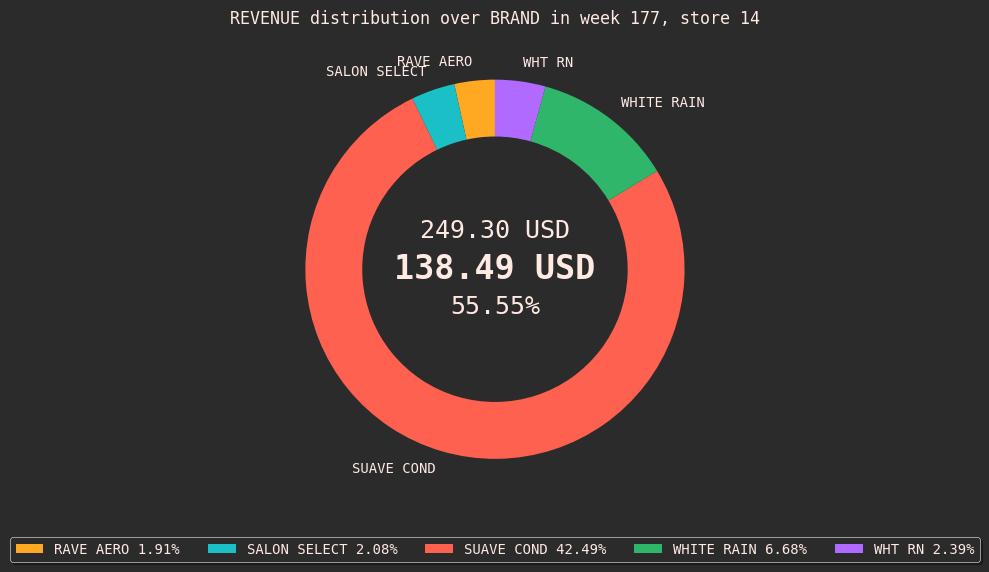

In [10]:
pie_chart(df_week, "REVENUE", "BRAND")

Examining the first pie chart showcasing revenue distribution amongst the top brands, we observe that the total revenue accumulated across all brands was \\$249.30. Out of this total, the top five brands: Rave Aero, Salon Select, WHT RN, White Rain, and Suave Cond, accounted for \\$138.49, which corresponds to 55.55% of the overall revenue. Remarkably, Suave Cond emerged as the week's leading brand, capturing a significant 42.49% of the revenue among these top contenders.

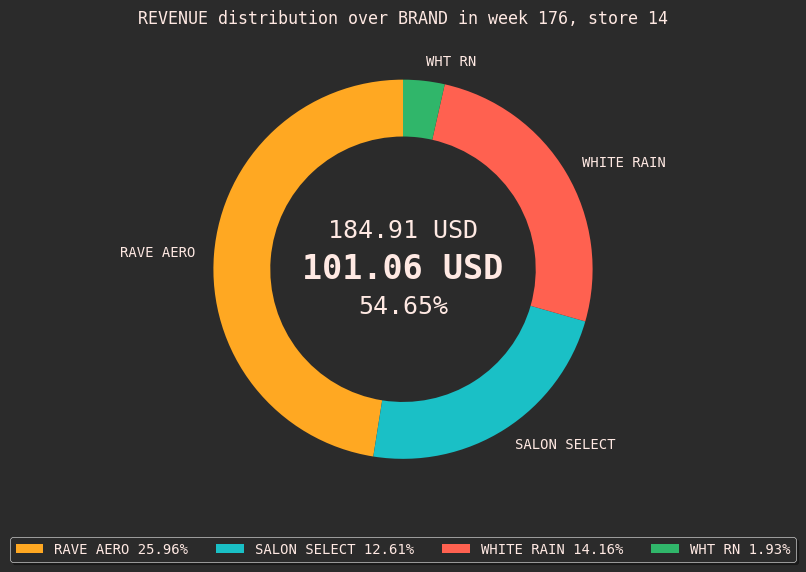

In [11]:
pie_chart(df_week_last, "REVENUE", "BRAND")

interestingly, when comparing this data to the previous week's (Week 176) revenue, it appears that the top revenue earner of Week 177, Suave Cond, had no sales in the previous week. This drastic turnaround suggests an intriguing shift in customer behavior or the effectiveness of sales strategies implemented for this brand or sub products for the brand during Week 177.

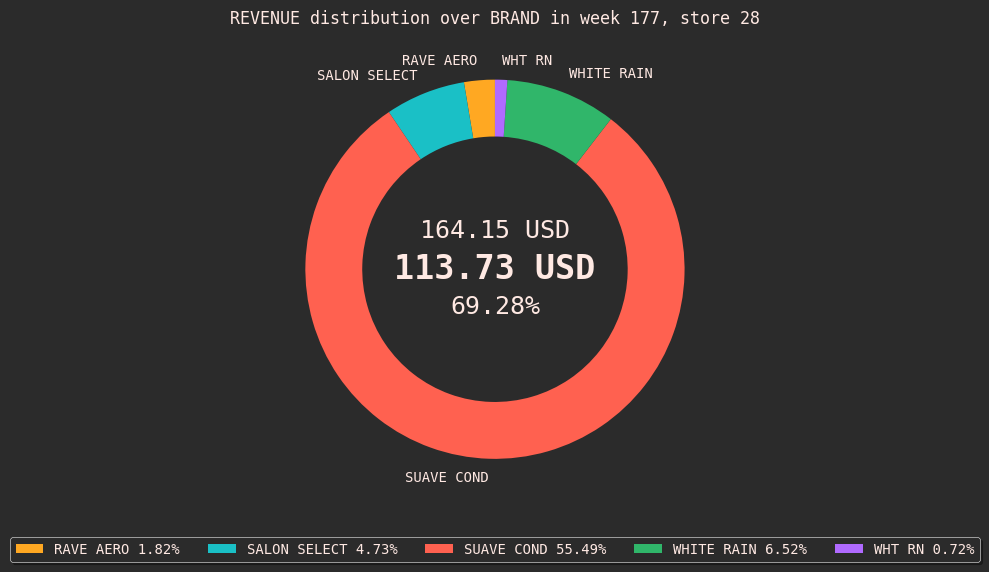

In [12]:
pie_chart(df_week_second, "REVENUE", "BRAND")

Comparative analysis with a different store, Store 28, during the same period (Week 177), reveals a similar trend. Suave Cond also held a dominant position in Store 28, reinforcing its impressive performance across different locations.

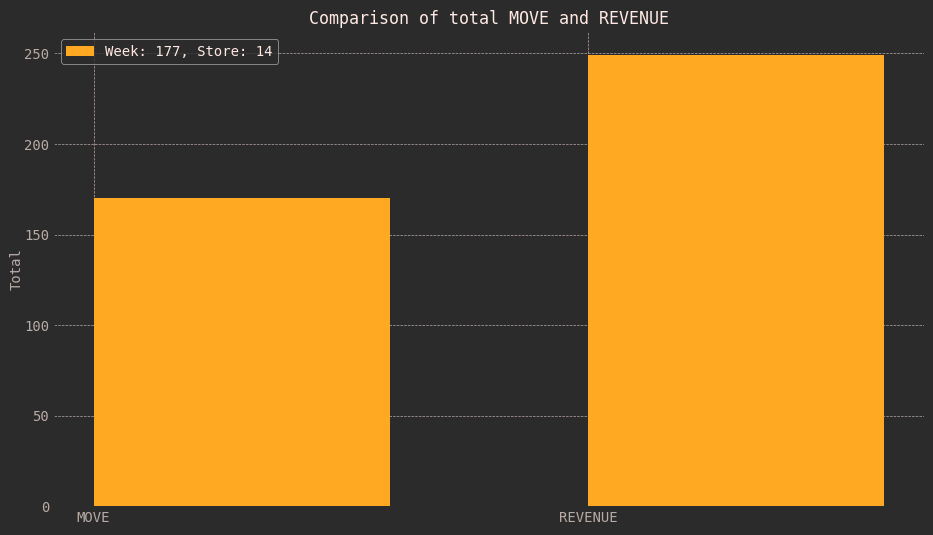

In [13]:
compare_weeks([df_week],[label_create(df_week)])

The bar chart demonstrating the relationship between total sales units (or 'move') and revenue at store 14 for week 177 reveals some additional insights. Although the sales units hovered around 175, the revenue reached nearly \\$250, confirming the previously discussed total revenue of \\$249.30.

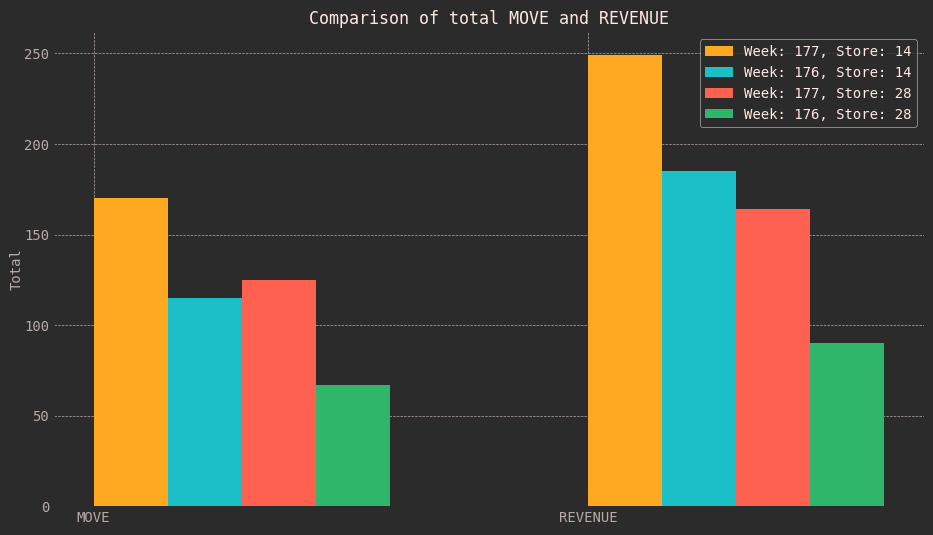

In [14]:
compare_weeks([df_week, df_week_last, df_week_second, df_week_last_second], 
              [label_create(df_week), label_create(df_week_last), label_create(df_week_second), label_create(df_week_last_second)])

Wee can also comparison between store 14 and store 28 during weeks 176 and 177 to get an overview of total sales units versus revenue. This comparison shows us store 14's higher performance with a total revenue of \\$249.30, compared to store 28's \\$164.15 during week 177. This corroborates our earlier observation of store 14's overall stronger performance during this particular week.

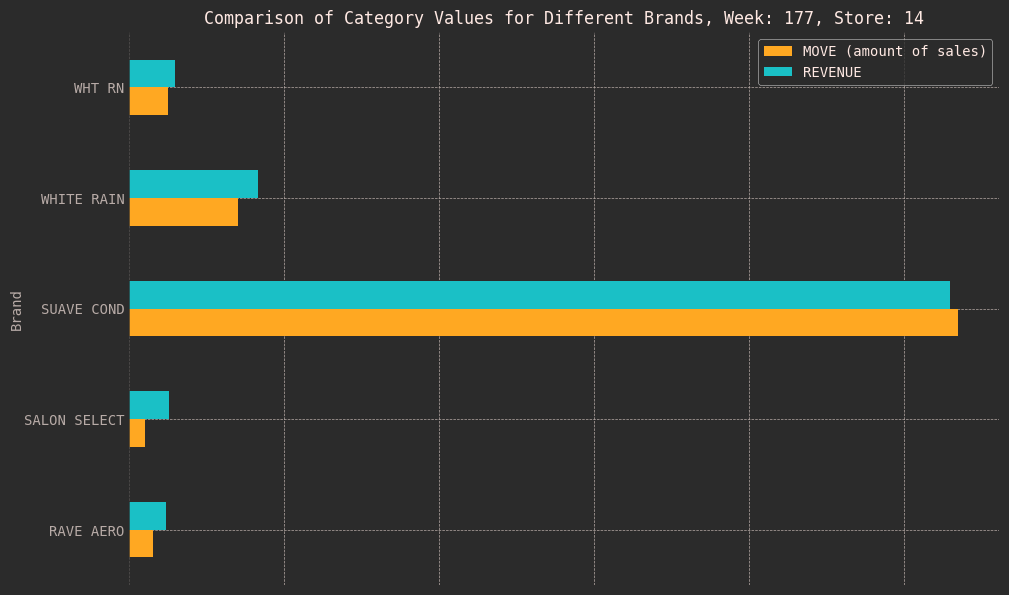

In [15]:
selected_columns = ["MOVE","REVENUE"]
horizontal_bar(df_week, selected_columns, split_by_brand=True, legend_labels = ["MOVE (amount of sales)", "REVENUE"], title = f'Comparison of Category Values for Different Brands')

Taking a deeper look at the individual performance of each of the top five brands, we can discern some compelling findings from the sales versus revenue bar graph. Despite having the lowest number of sales, Salon Select manages to achieve the highest profit per sale. This suggests a higher pricing strategy or perhaps a more premium market positioning for this brand. On the other hand, Suave Cond registers more sales than revenue. This suggests that some of the products under the Suave Cond brand may have been on sale or discounted during this period

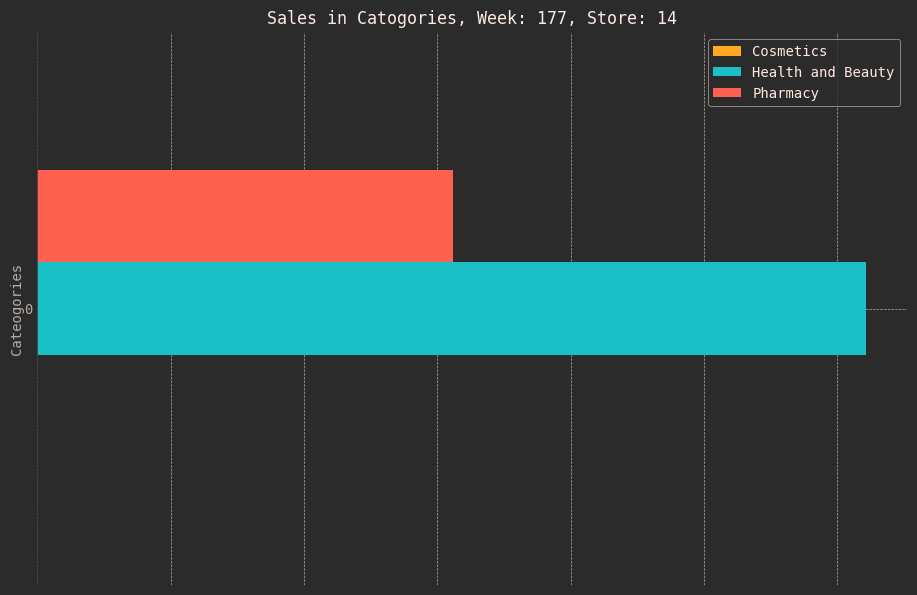

In [16]:
selected_columns = ["COSMETIC", "HABA","PHARMACY"]
horizontal_bar(df_week, selected_columns, legend_labels = ["Cosmetics", "Health and Beauty", "Pharmacy"], title = "Sales in Catogories")

In this graph we get further insights across different sales categories within the store: cosmetics, health and beauty, and pharmacy. During this week in Store 14, the cosmetics category failed to register any sales. When comparing the pharmacy and health and beauty categories, it becomes apparent that most of the sales are coming from the health and beauty section. This data suggests that the health and beauty sector might be a more productive focus area for sales improvement initiatives.

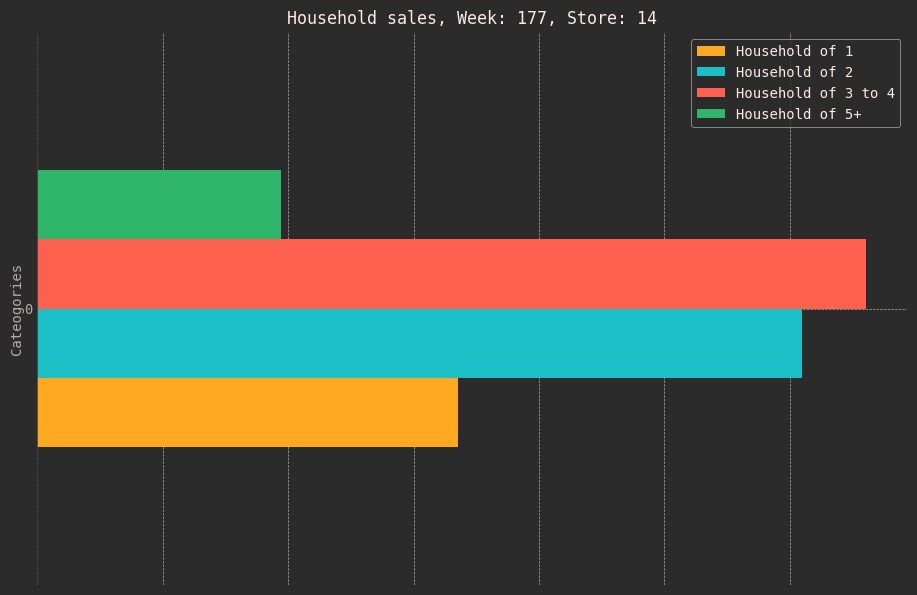

In [17]:
selected_columns = ["HSIZE1","HSIZE2","HSIZE34","HHLARGE"]
horizontal_bar(df_week, selected_columns, legend_labels = ["Household of 1", "Household of 2", "Household of 3 to 4", "Household of 5+"], title = "Household sales")

This graph shows sales by different household sizes. Here we see that households with five or more members contribute the least to the sales volume. Conversely, households consisting of 2 to 4 members seem to be the primary driver of sales, indicating a potentially key demographic for marketing efforts. While households of one, seems to be well placed in the middle.

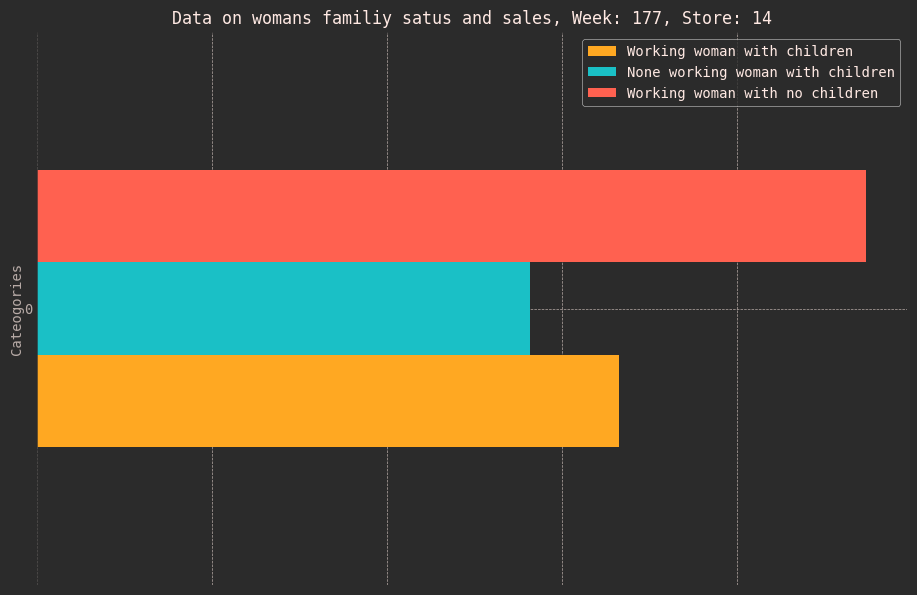

In [18]:
selected_columns = ["WRKCH","NWRKCH","WRKWNCH"]
horizontal_bar(df_week, selected_columns, legend_labels = ["Working woman with children", "None working woman with children", "Working woman with no children"], title = "Data on womans familiy satus and sales")

Lastly lets examen the sales trends related to women's work and family status. Working women without children appear to purchase more shampoo than women with children, and women without jobs and children. This might imply a higher disposable income and selfcare expenditure among this group, indicating a valuable consumer segment to cater to in future marketing strategies.

## Sales Report (month 5, all stores)
----
----

The sales report for all stores during the fifth month of the year 1993.

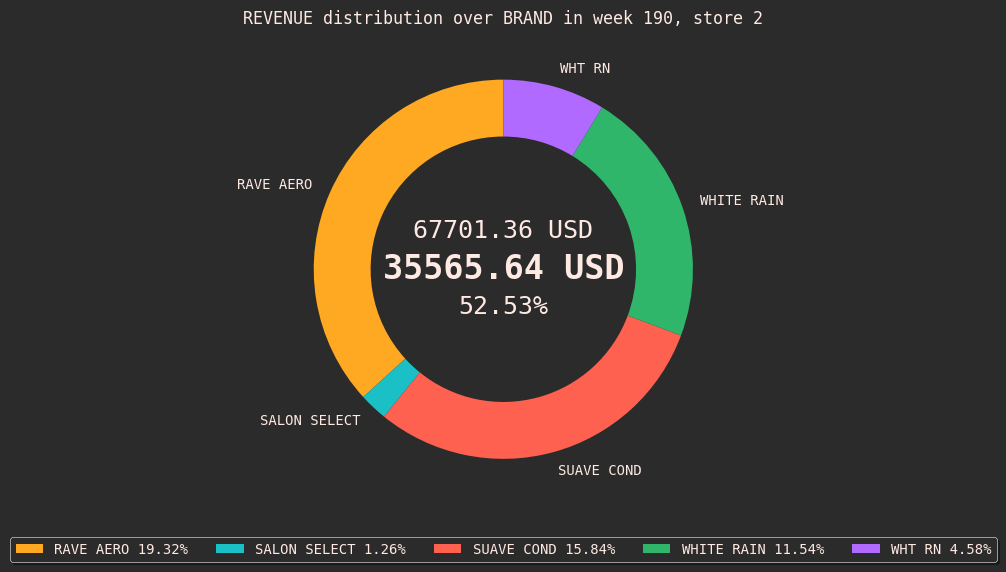

In [19]:
pie_chart(df_month, "REVENUE", "BRAND")

From the pie graph depicting revenue distribution among the top brands, we note that the total revenue from shampoo sales during this period was \\$67,701.36. Impressively, our top five brands; Rave Aero, Salon Select, WHT RN, White Rain, and Suave Cond accounted for a substantial 52.53% of this revenue, which translates to a significant sum of \\$35,565.64.

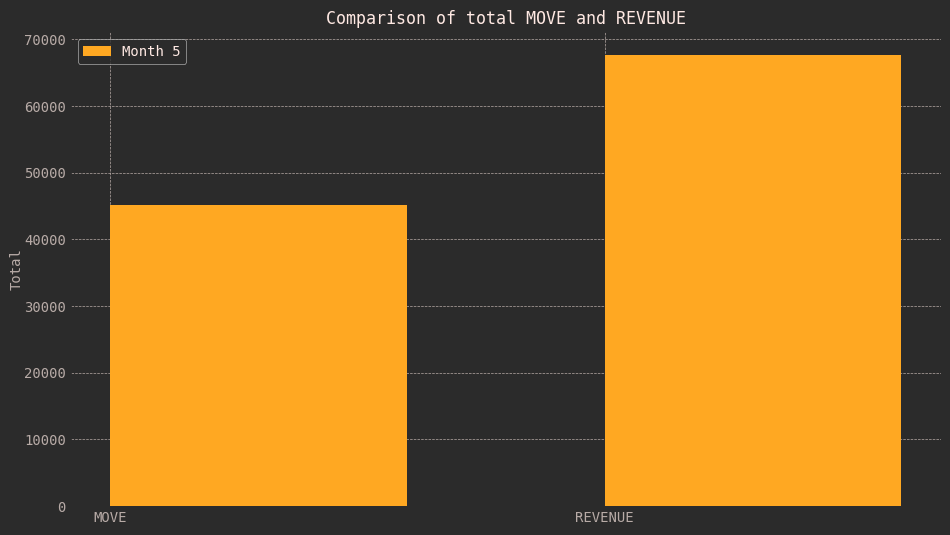

In [20]:
compare_weeks([df_month],["Month 5"])

This bar graph shows total sales units against total revenue across all stores provides further perspective. While sales units (move) hovered around the 45,000 mark, the total revenue was just under of $70,000, reflecting a healthy return on sales.

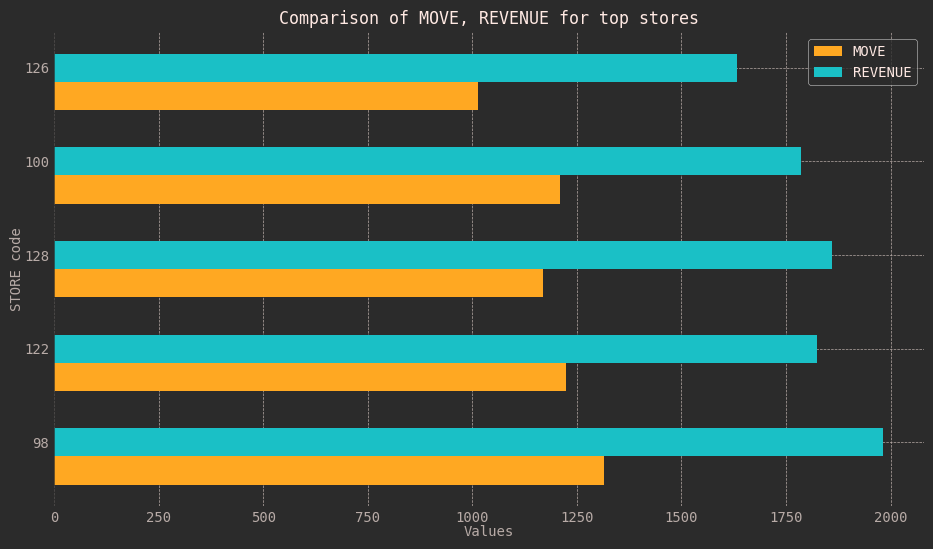

In [21]:
selected_columns = ["MOVE", "REVENUE"]
selection = 'top'
horizontal_month_bar(df_month, selected_columns, selection)

Here we have sales (move) and revenue units split into our top performing stores for analyzing. The revenue and sales units bar graph spotlights store 98 as the frontrunner, boasting close to \\$2000 in revenue and 1300 in sales. Meanwhile, store 126 stands at the lower end with just over 1000 in sales and around \\$1600 in revenue.

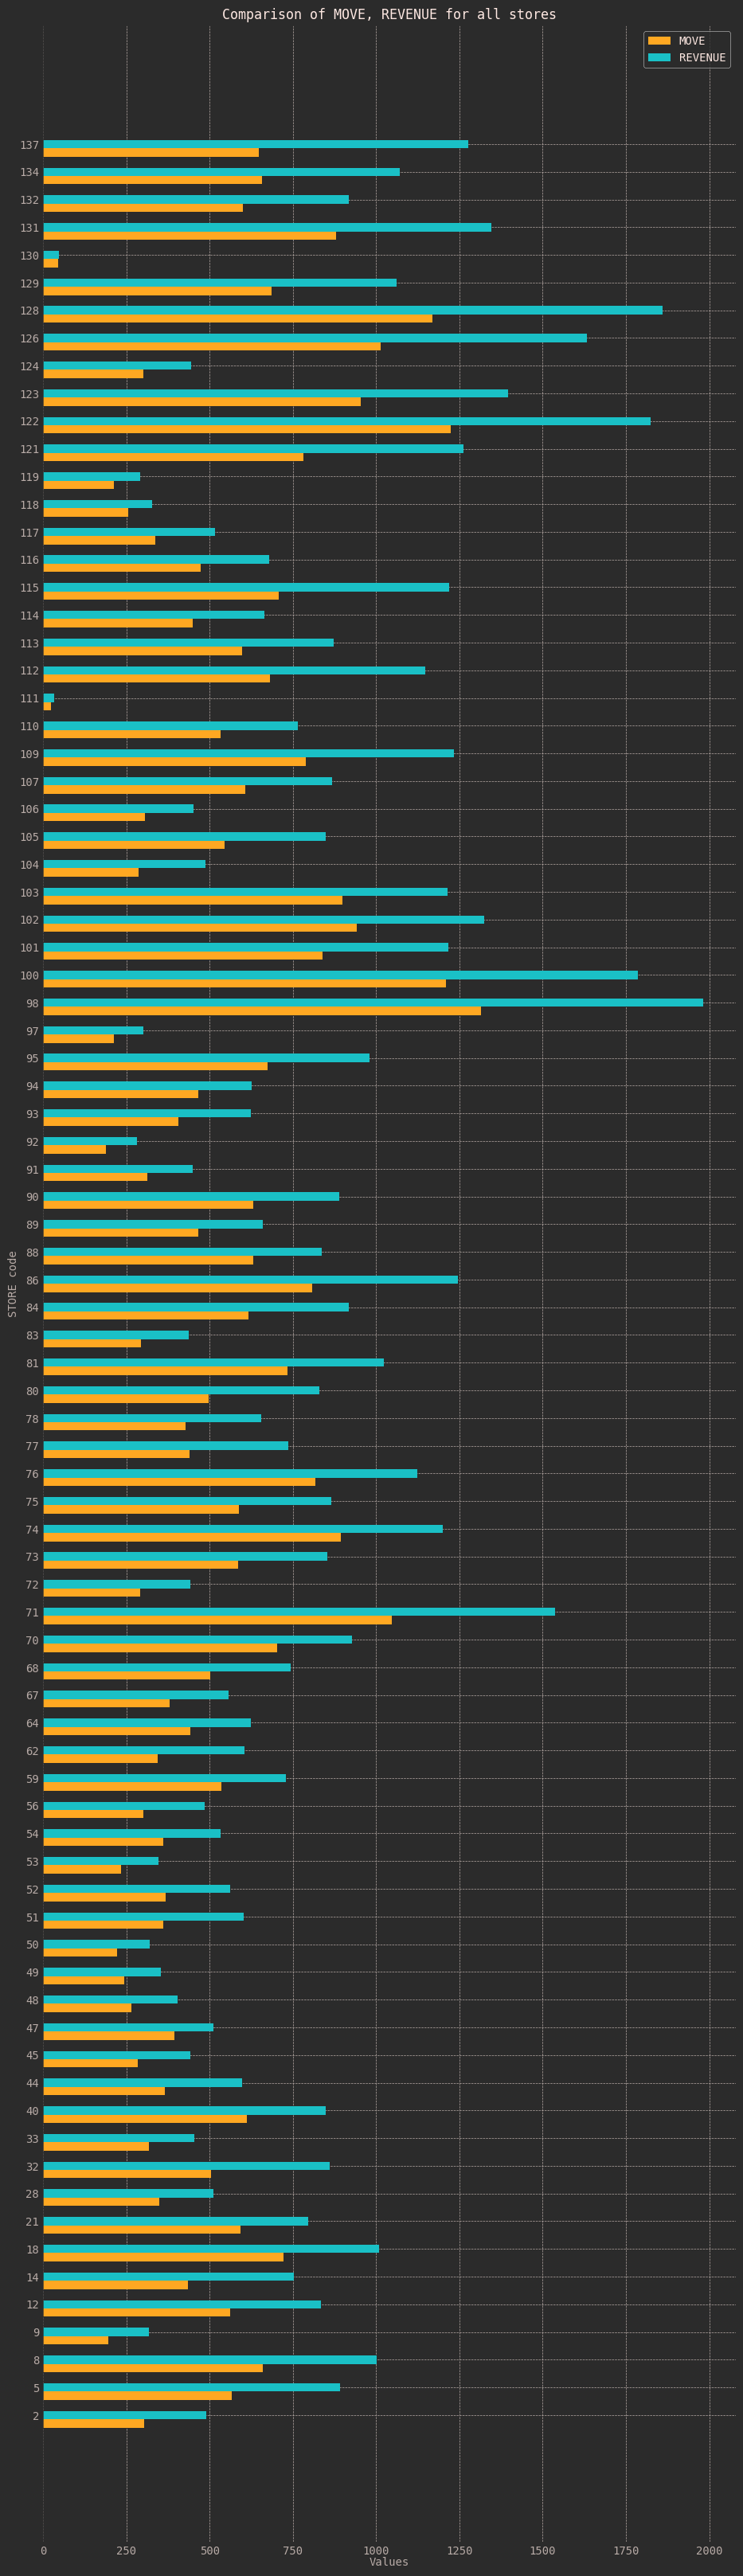

In [22]:
selected_columns = ["MOVE", "REVENUE"]
selection = 'all'
horizontal_month_bar(df_month, selected_columns, selection)

For completeness, an all encompassing bar graph portrays the performance of all the stores. It surfaces the stores that appear to be struggling, particularly Stores 130, 111, 9, and 50, which are registering the lowest performance metrics. As well the average performence seems to hover around 500.

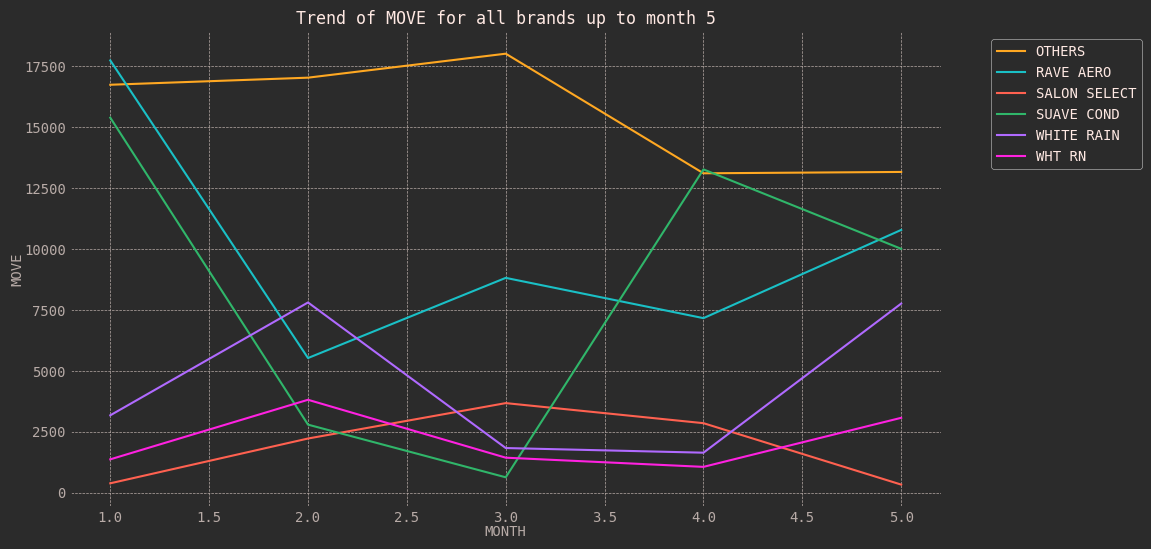

In [23]:
line_graph(df_raw, 'MONTH', 'MOVE', 5)

Here in this line graph, we are tracing the sales evolution of each brand over the last five months reveals insightful trends. The "other" category representing the smaller brands, demonstrates stable and high sales. In contrast, among the top brands, Suave Cond and Rave Aero exhibit high fluctuations, indicating varying sales performance over time.

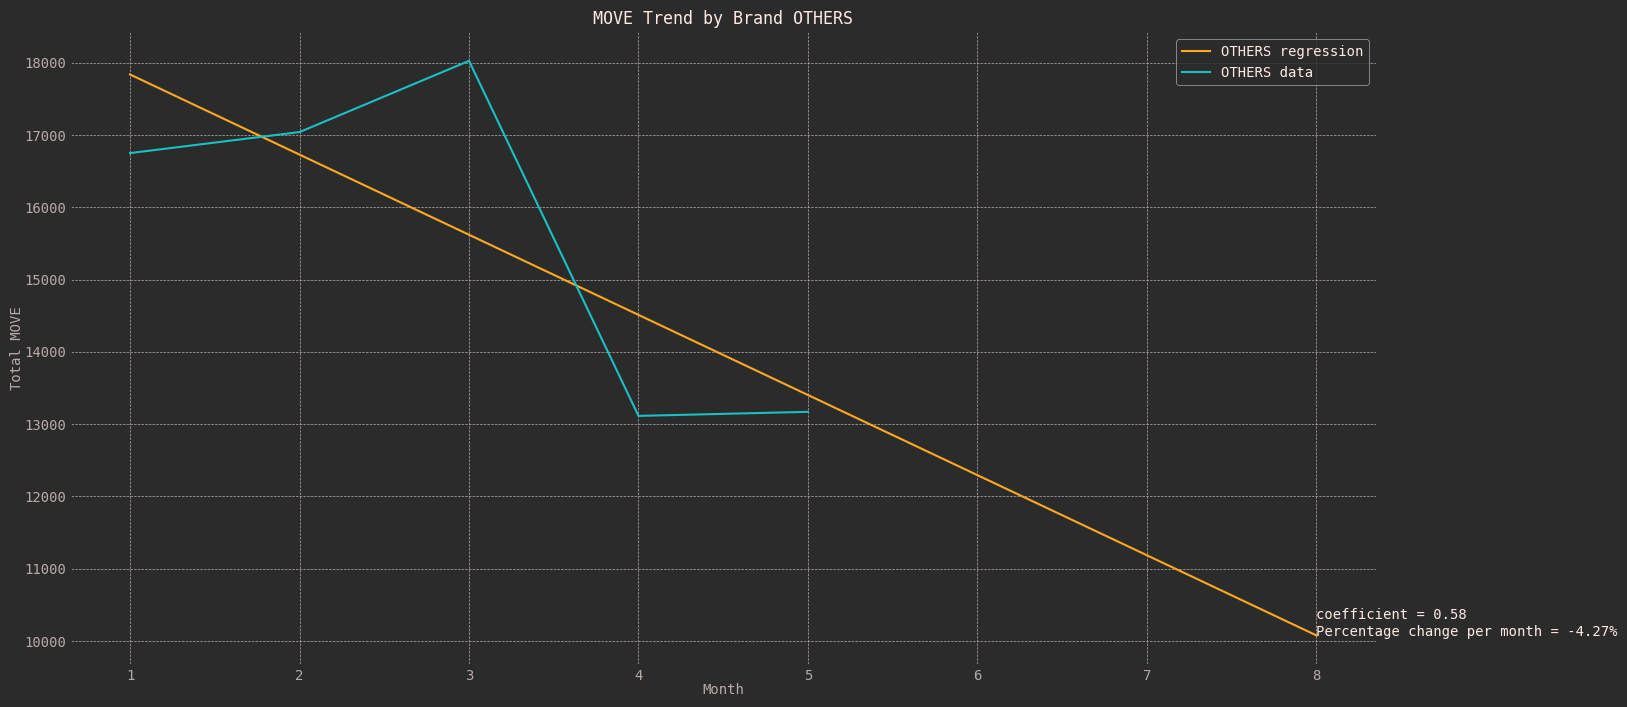

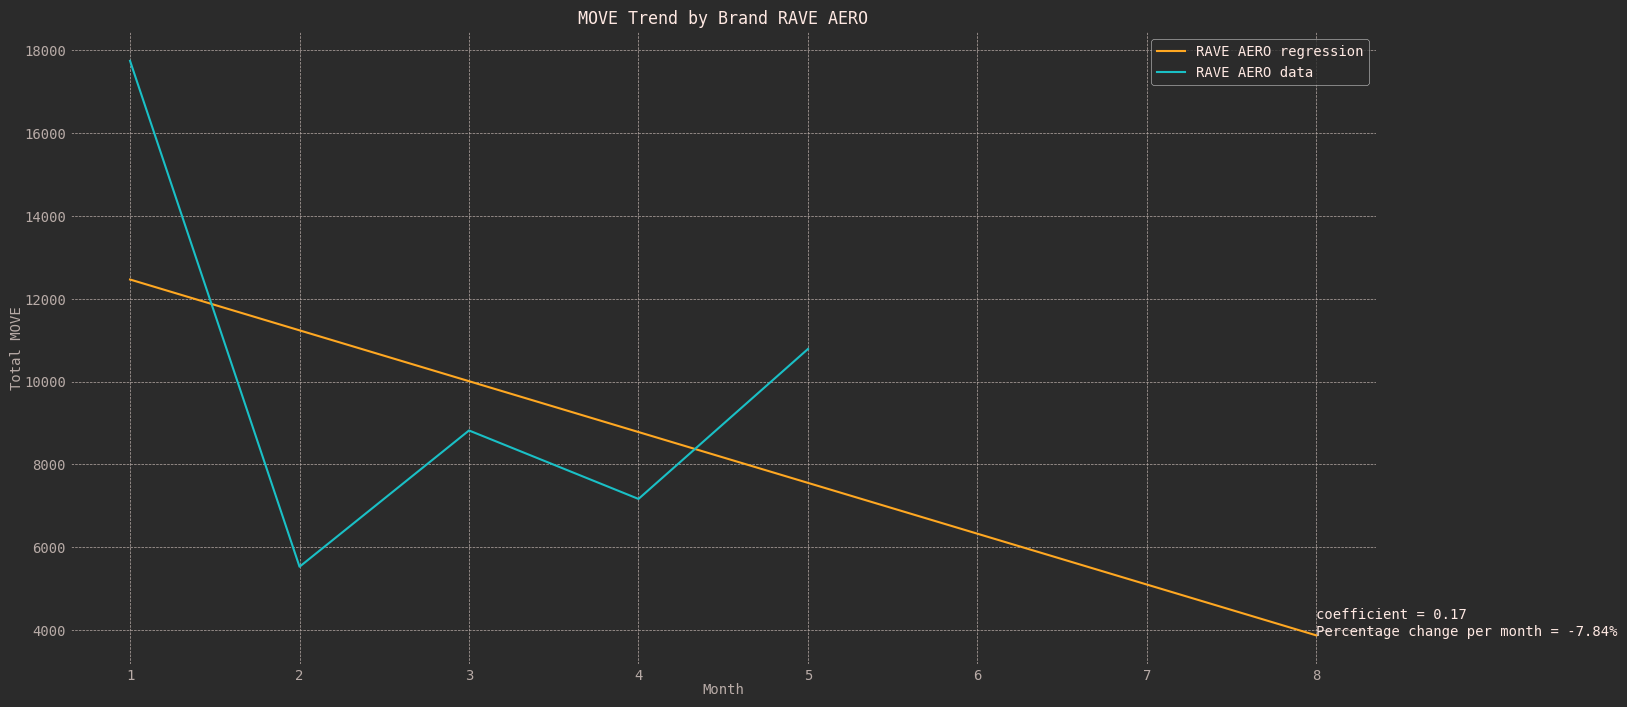

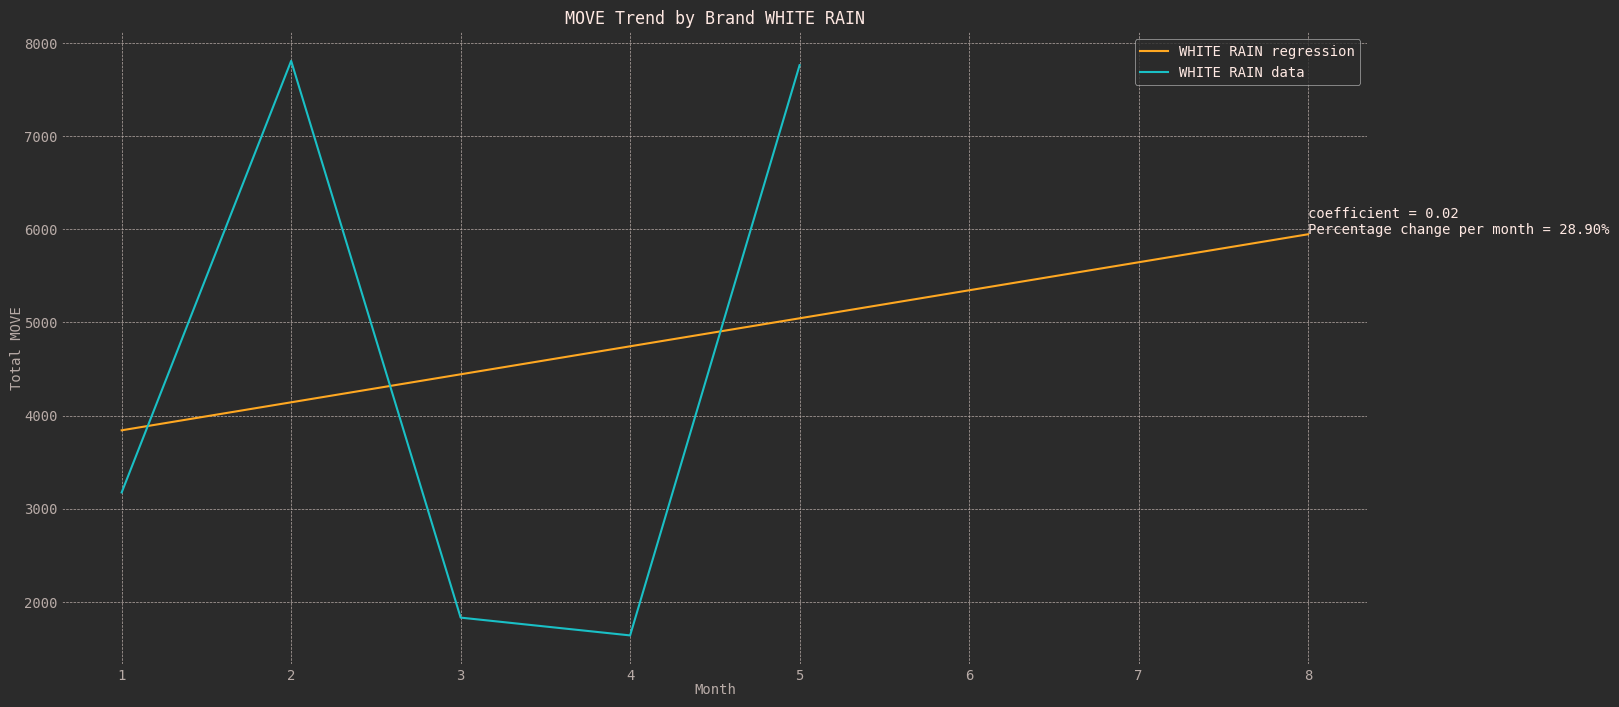

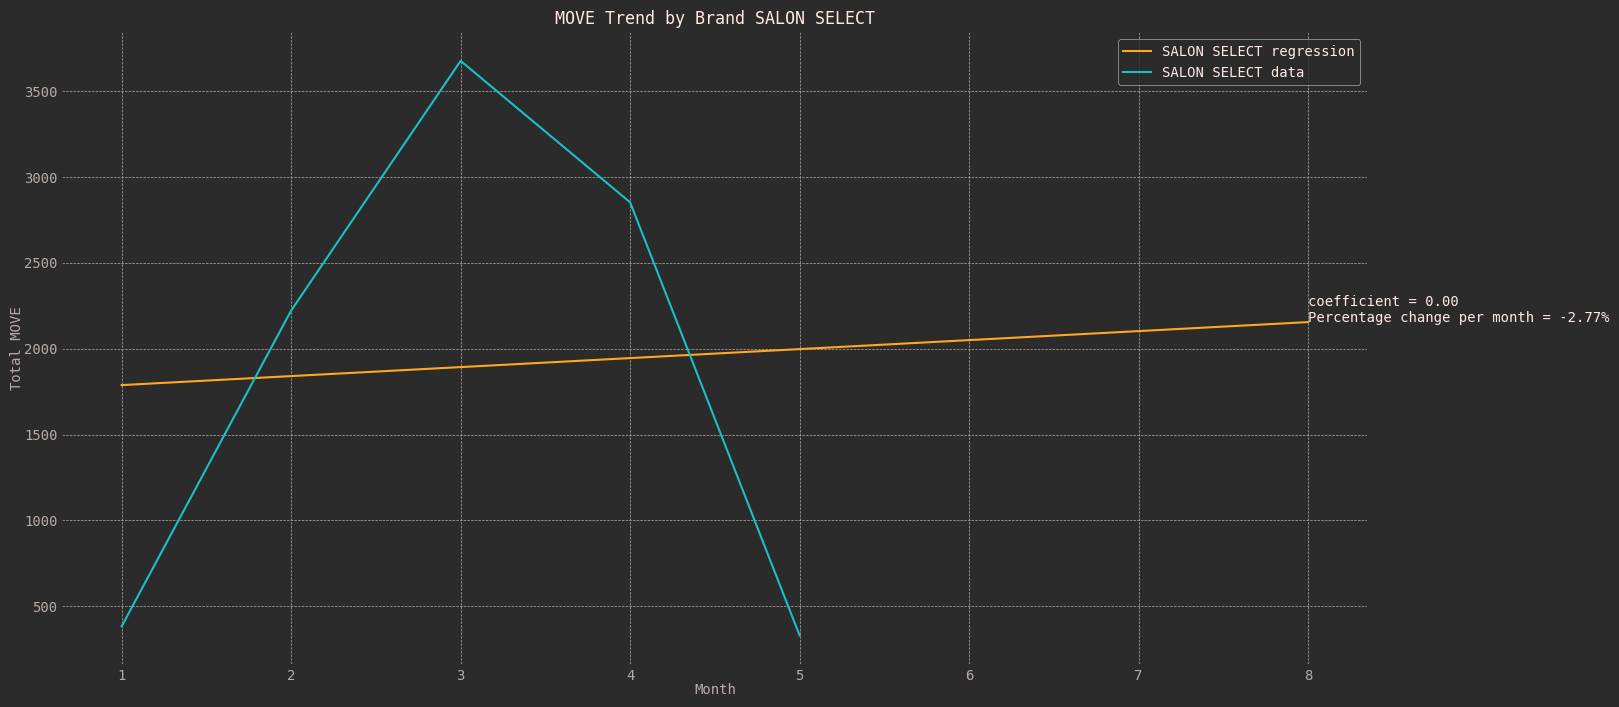

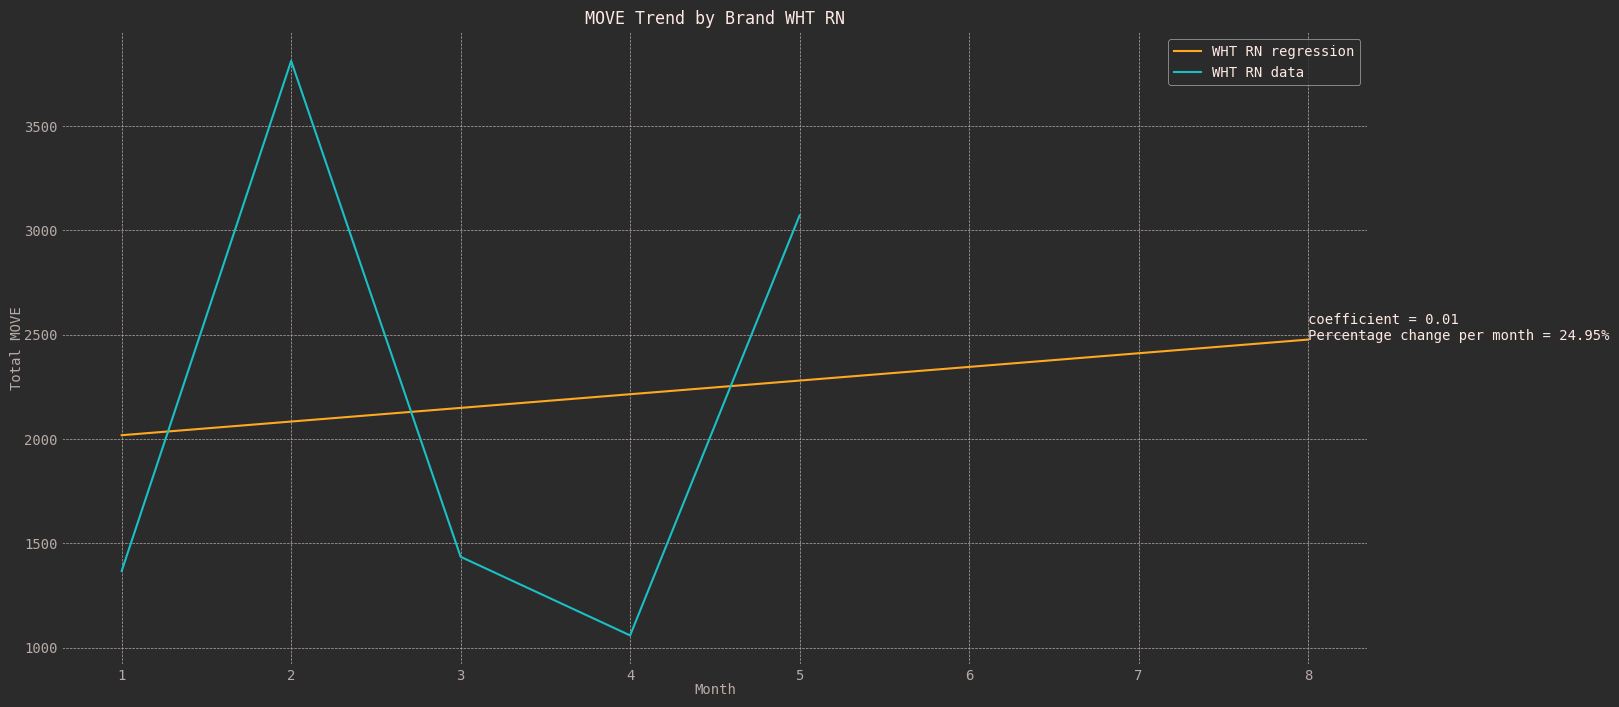

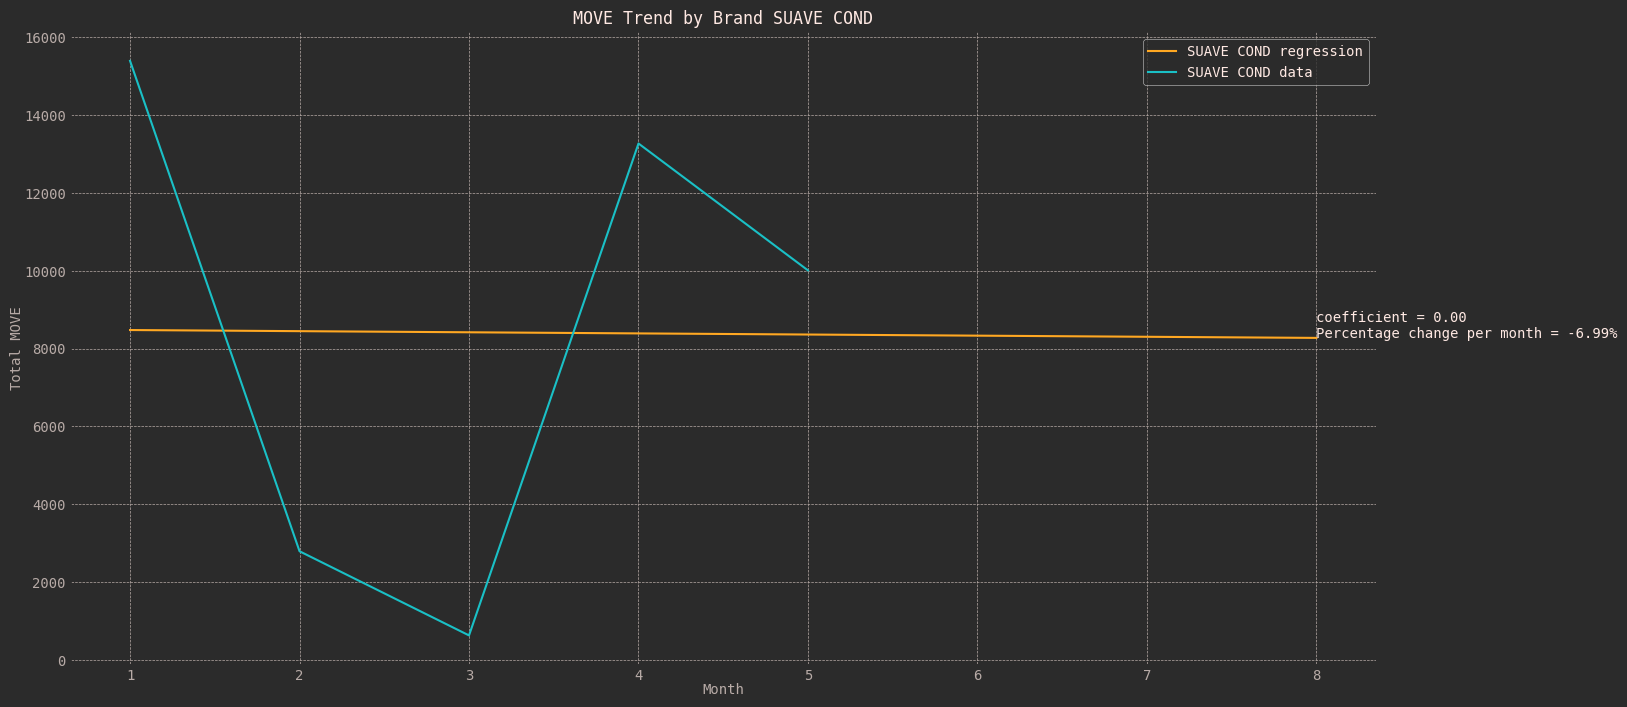

In [24]:
# Category I want to predict
category = "MOVE"

# Number of months I want to predict into the future
future_months = 3

for brand in df_raw["BRAND"].unique():
    brand_trend_graph(df_raw, brand, min_month=1, max_month=5, column=category, future_months=future_months)

Analysing the line graphs, tracking each brand's sales performance over the past five months, has uncovered some noteworthy trends and predictions. To help visualize these trends, I have implemented some regression lines. 

Of particular note, we observe the "Other" category and "Rave Aero" brand appear to be on a declining trajectory, which indicates a potential need for strategic adjustments to boost their sales performance.

Contrarily, the brands "White Rain", "Salon Select", and "WHT RN" show an encouraging upward trend, suggesting that current strategies are effective and may be worth reinforcing to maintain this momentum.

Lastly, the "Suave Cond" brand exhibits a stable trend line. While this suggests consistent performance, it's worth exploring opportunities for growth to prevent stagnation.

Alongside these historical trends, the graph also presents a three-month prediction based on current trajectories. These forecasts, though subject to change, can provide valuable information and help guiding future decision making. As always, it's crucial to continue monitoring these trends closely and adjust strategies as necessary to optimize performance.

### Future Stores
--------
------

In [25]:
# NOTE this might take some time, normaly less then a minute tho
df_travel = df_raw
geolocator = Nominatim(user_agent="geoapiZIPtoCoordinates")

# unique ZIP
unique_zip_codes = df_travel['ZIP'].unique()

# Geocode ZIP codes
zip_code_dict = {}
for zip_code in unique_zip_codes:
    # Assume 'USA"
    location = geolocator.geocode(f'{int(zip_code)}, USA')
    if location:
        zip_code_dict[zip_code] = (location.latitude, location.longitude)

df_travel['latitude'] = df_travel['ZIP'].map(lambda x: zip_code_dict[x][0])
df_travel['longitude'] = df_travel['ZIP'].map(lambda x: zip_code_dict[x][1])

In [26]:
def heatmap(attributes = ["MOVE", "REVENUE", "PROFIT"], HTML_CHECK = False, template = None):
    # Create a Map instance
    geo_heat_map = folium.Map(location=[df_travel["latitude"].mean(), df_travel["longitude"].mean()])

    # Add different heatmaps
    for attribute in attributes:
        HeatMap(data=df_travel[["latitude", "longitude", attribute]].groupby(["latitude", "longitude"]).sum().reset_index().values.tolist()).add_to(folium.FeatureGroup(name=attribute).add_to(geo_heat_map))
    
    if HTML_CHECK:
        # create a text template
        if template == None:
            print("[Error]\tmissing HTML templeate code.\n\tAdd the 'template' parameter with the HTML code you want to display")
            return None

        # MacroElement
        macro = MacroElement()
        macro._template = Template(template)
        geo_heat_map.get_root().add_child(macro)

    # Add LayerControl
    folium.LayerControl().add_to(geo_heat_map)
    return geo_heat_map

def template_create(entries):
    base_template = """
        {% macro html(this, kwargs) %}
        <style>
            .legend {
                position: fixed;
                bottom: 25px;
                left: 25px;
                min-width: 150px;
                max-width: 350px;
                height: auto;
                background-color: #2b2b2b;
                color: white;
                z-index: 9999;
                font-size: 14px;
                padding: 10px;
                border: 2px solid grey;
                border-radius: 10px;
                transition: all 0.3s ease;
            }

            .legend:hover {
                transform: scale(1.1);
            }

            .legend p {
                margin: 0;
                line-height: 1.5;
            }

            .legend .title {
                text-transform: uppercase;
                color: #ffa822;
                font-weight: bold;
            }

            .legend .content {
                color: #30B66A;
            }

            .legend .content:hover {
                color: #B06AFF;
                transition: all 0.3s ease;
            }
        </style>

        <div class="legend">
            <p class="title">LAYER DESCRIPTION:</p>
    """

    for key, value in entries.items():
        base_template += f'<p class="content"><b>{key}:</b> {value}</p>\n'
    
    base_template += """
        </div>
        {% endmacro %}
        """

    return base_template

In [27]:
entries = {
    "MOVE": "Represents the number of sales in a store",
    "REVENUE": "Total revenue for the stores in the region",
    "PROFIT": "Total profit for the stores in the region",
}

template = template_create(entries)

geo_heat_map_sale = heatmap(HTML_CHECK=True, template=template)
geo_heat_map_sale

In [28]:
entries = {
    "COSMETIC": "Area where cosmetics are sold",
    "HABA": "Area where health and beauty products are sold",
    "PHARMACY": "Area where pharmaceutical products are sold",
}

template = template_create(entries)

geo_heat_map_catogory = heatmap(attributes = ["COSMETIC", "HABA", "PHARMACY"],HTML_CHECK=True, template=template)
geo_heat_map_catogory

In [29]:
entries = {
    "HSIZE1": "Household with one",
    "HSIZE2": "Household with two",
    "HSIZE34": "Household with 3 to 4",
    "HHLARGE": "Household with 5+",
}

template = template_create(entries)

geo_heat_map_house = heatmap(attributes = ["HSIZE1", "HSIZE2", "HSIZE34", "HHLARGE"], HTML_CHECK=True, template=template)
geo_heat_map_house

In [30]:
entries = {
    "WORKWOM": "Women that works",
    "WRKCH5": "Women that work, with children 5year or younger",
    "WRKCH17": "Women that work, with children 17year or younger",
    "NWRKCH5": "Women that does not work, with children 5year or youngerd",
    "NWRKCH17": "Women that does not work, with children 17year or youngerd",
    "NWRKCH": "Women that does not work, with children",
    "WRKWNCH": "Women that work, with no children",
}

template = template_create(entries)

geo_heat_map_wom = heatmap(attributes = ["WORKWOM", "WRKCH5", "WRKCH17", "NWRKCH5", "NWRKCH17", "NWRKCH", "WRKWNCH"], HTML_CHECK=True, template=template)
geo_heat_map_wom

Presented here are several heatmap visualizations over different stores based in Chicago, each focusing on different aspects of our data. These maps are drawn from the raw data set, spanning one year.

The first map offers a spatial representation of key financial metrics: sales (move) units, revenue, and profit across the city. This view gives us a sense of which areas generate the most value for our business.

The second map focuses on sales categories, showcasing the distribution of sales across different sectors; Cosmetics, Health and Beauty, and Pharmacy. This heatmap enables us to understand which product categories are popular in different regions.

The third map visualizes sales data by household size, ranging from single person households to households of five or more. It provides insights into which areas have the largest households, a potentially important factor in driving certain types of sales.

The final map pertains to women's family status and job status.

These maps collectively offer a overview of the sales operations. By overlaying these maps, one can identify locations with high consumer traffic and other sales factores that can be of interest. A general analysis suggests promising locations like Naperville, Wheeling, North Elston Avenue, and West Addison Street as potential areas for new stores. These locations are currently serving high demand markets and might be nearing their maximum capacity. More information and analyzing would be needed to find the optimal place, but these areas are a good starting point